In [195]:
# import modules
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import sqrt

# escolha o conjunto de imagens
path = '../../../images/virtual/'
images = glob(path + '15x11/original/new_workflow_test/*.jpg')

In [196]:
len(images)

50

In [218]:
counter = 0
image_set = []

i = np.random.choice(np.arange(0,50),30, replace=False)

for idx in i:

    image_set.append(images[idx])

In [219]:
image_set

['../../../images/virtual/15x11/original/new_workflow_test\\image41.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image14.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image48.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image42.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image3.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image36.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image30.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image5.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image32.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image4.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image33.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image35.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image37.jpg',
 '../../../images/virtual/15x11/original/

In [55]:
# Funções de calibração

#Reconstrução do tabuleiro
def construct3DPoints(patternSize,squareSize):
    X = np.zeros((patternSize[0]*patternSize[1],3), np.float32)
    X[:,:2] = np.mgrid[0:patternSize[0],0:patternSize[1]].T.reshape(-1,2)
    X = X * squareSize # Square size não interfere na calibração -> somente um fator de escala
                       # o square size não é utilizado na calibração dos cara de stanford
    return X

#Detectando os corners
def detectCorners(images, boardPoints, patternSize):
    worldPoints = []
    imagePoints = [] 

    img_size = 0
    counter = 0
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = gray.shape[::-1]
        ret, corners = cv2.findChessboardCornersSB(gray, patternSize, None)
        if ret == True:
            #print("Corners found in image " + str(fname)) #- see if corners are found 
            #corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
            worldPoints.append(boardPoints)
            imagePoints.append(corners)
            counter+=1

    print("Corners found in " + str(counter) + " images")
    #print(img_size)
    return worldPoints, imagePoints, img_size

#Descobrindo os intrisicos, extrinsecos e o erro de reprojeção 
def calibrate(images, useFisheye, patternSize, squareSize, details = True):

    boardPoints = construct3DPoints(patternSize, squareSize)

    worldPoints, imagePoints, imgSize = detectCorners(images, boardPoints, patternSize)

    if useFisheye:
        flagsCalib = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_FIX_SKEW+cv2.fisheye.CALIB_CHECK_COND
        calibrateCriteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,30, 1e-12)

        ret, cameraMatrix, k, R, t = cv2.fisheye.calibrate(np.expand_dims(np.asarray(worldPoints), -2), imagePoints, imgSize, None, None,
                                                                    flags=flagsCalib,criteria=calibrateCriteria)
    else:
        flagsCalib = cv2.CALIB_RATIONAL_MODEL

        ret, cameraMatrix, k, rvecs, tvecs, stdIntrinc, stdExtrinsic, perViewError = cv2.calibrateCameraExtended(worldPoints, imagePoints, imgSize, None, None,
                                                                flags=flagsCalib)
    if details:
        print("RMS re-projection error:", ret)
        print("The median re-projection error", np.median(perViewError))
        print("Camera Matrix:\n", cameraMatrix)
        print("Distortion Parameters:\n", k)

    return cameraMatrix, k, rvecs, tvecs, stdIntrinc, stdExtrinsic, perViewError

def calculate_mean_error(image_set, pattern_size, square_size, camera_matrix, distortion, per_view_error = False):
    
    # Create empty arrays for rotation and translation vectors
    rvecs = []
    tvecs = []
    errors = []
    
    # Define the world board points
    board_points = construct3DPoints(pattern_size, square_size)
    board_points = board_points.astype('float32')
    
    # Calculate image points in each image
    for image in image_set:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Detect chessboard corners in the image
        ret, detected_image_points = cv2.findChessboardCornersSB(gray, pattern_size, None)
        
        # If it was detected
        if ret == True: 

            # Calculate extrinsic parameters 
            _, rvec, tvec = cv2.solvePnP(board_points, detected_image_points, camera_matrix, distortion)
            rvecs.append(rvec)
            tvecs.append(tvecs)

            # Calculate projected image points
            projected_image_points, _ = cv2.projectPoints(board_points, rvec, tvec, camera_matrix, distortion)

            # Find the Euclidean Distance between projected and detected image points
            error = cv2.norm(detected_image_points, projected_image_points, normType= cv2.NORM_L2) / len(projected_image_points)
            
            errors.append(error)
            
            if per_view_error:
                print(f"Mean Error of Image {image}:", error, "px")
    
    mean_error = np.median(errors)
    
    print("Median error: ", mean_error)
    
    return mean_error

def calculate_rms_error(image_set, pattern_size, square_size, camera_matrix, distortion, per_view_error = False):
    
    # Create empty arrays for rotation and translation vectors
    rvecs = []
    tvecs = []
    errors = []

    # Define the world board points
    board_points = construct3DPoints(pattern_size, square_size)

    # Calculate the detected image points
    for image in image_set:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Detect chessboard corners in the image
        ret, corners = cv2.findChessboardCornersSB(gray, pattern_size, None)

        # If it was detected
        if ret == True:
            
            # Calculate extrinsic parameters
            _, rvec, tvec = cv2.solvePnP(board_points, corners, camera_matrix, distortion)
            rvecs.append(rvec)
            tvecs.append(tvecs)

            # Calculate projected image points
            image_points, _ = cv2.projectPoints(board_points, rvec, tvec, camera_matrix, distortion)

            # Find the Euclidean Distance between projected and detected image points
            error = cv2.norm(corners, image_points, normType= cv2.NORM_L2) / sqrt(len(image_points))
            errors.append(error)
            if per_view_error:
                print(f"RMS Error of Image {image}:", error, "px")

    rms_error = np.median(errors)

    print("Median RMS error: ", rms_error)

    return rms_error

Calibração Inicial - Detectar Outliers

In [220]:
# Calibração Inicial 
camera_matrix, distortion, rotation, translation, stdInt, stdExt, perViewError = calibrate(image_set, useFisheye = False, patternSize = (15,11), squareSize = 30)

perViewError = perViewError.flatten()

Corners found in 30 images
RMS re-projection error: 0.3393170194822197
The median re-projection error 0.3330588934782832
Camera Matrix:
 [[412.81819372   0.         240.73206042]
 [  0.         412.806862   240.35418802]
 [  0.           0.           1.        ]]
Distortion Parameters:
 [[-2.70750554e+01  2.01360279e+02  8.04024919e-05  7.11555092e-04
  -2.35934416e+02 -2.70733539e+01  2.01314091e+02 -2.35622600e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [221]:
rms_error =  0.3330588934782832

In [222]:
perViewError.std()

0.04178597392281371

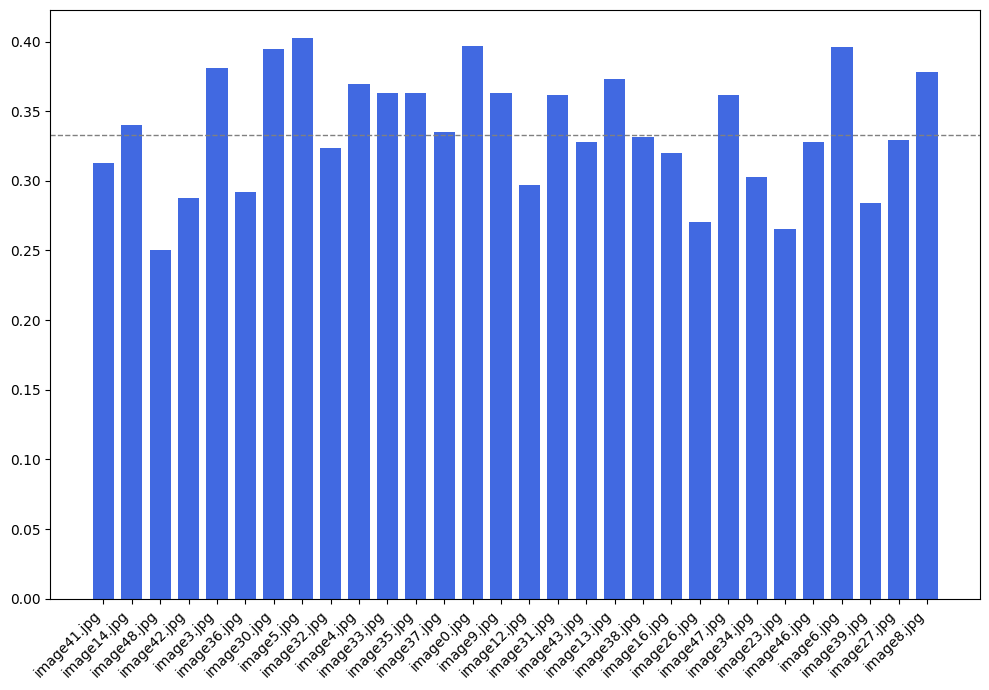

In [223]:
import os

image_files = []
for image in image_set:
    nome_arquivo = os.path.basename(image)
    image_files.append(nome_arquivo)


plt.figure(figsize=(10,7))
plt.bar(image_files, perViewError, color = 'royalblue', width=.75)

plt.axhline(y=rms_error, color='gray', linestyle='--', linewidth=1, label=f'Média: {rms_error:.2f}')

plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos das imagens para melhor visualização
plt.tight_layout()  # Ajusta o layout para se encaixar bem na figura
plt.show()

In [97]:
perViewError

array([0.1757935 , 0.25652837, 0.21777606, 0.33345834, 0.23290805,
       0.23010709, 0.21777606, 0.23617821, 0.21194765, 0.23897807])

In [62]:
def remove_images(limiar, error, images):
    new_set = []

    for idx, image in enumerate(images):

        if perViewError[idx] > (limiar + error.std()):
            new_set.append(image)

    return new_set

In [224]:
new_set = remove_images(limiar=rms_error, error = perViewError, images= image_set)

for image in new_set:
    image_set.remove(image)

image_set

['../../../images/virtual/15x11/original/new_workflow_test\\image41.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image14.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image48.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image42.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image36.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image32.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image4.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image33.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image35.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image37.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image9.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image12.jpg',
 '../../../images/virtual/15x11/original/new_workflow_test\\image31.jpg',
 '../../../images/virtual/15x11/original

In [225]:
len(image_set)

24

Calibração final - Divisão em Treino e teste

In [226]:
zeros = np.zeros(len(image_set))

images_train, images_test, _, _ = train_test_split(image_set, zeros, test_size=0.3) 

camera_matrix, distortion, rotation, translation, stdInt, stdExt, perViewError = calibrate(images_train, useFisheye = False, patternSize = (15,11), squareSize = 30)

error = calculate_rms_error(image_set=images_test, pattern_size=(15,11), square_size= 30, camera_matrix=camera_matrix, distortion=distortion)

Corners found in 16 images
RMS re-projection error: 0.31746385469361815
The median re-projection error 0.32376785857613777
Camera Matrix:
 [[412.67530463   0.         241.8385713 ]
 [  0.         412.51858645 239.52656472]
 [  0.           0.           1.        ]]
Distortion Parameters:
 [[-2.44904712e+01  1.12539448e+02 -1.00004561e-04  1.37491090e-03
   4.90537152e+02 -2.44835010e+01  1.12348171e+02  4.91847583e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
Median RMS error:  0.33525803718502734


Etapa K-fold Cross Validation - Encontrar indicadores de estabilidade


In [210]:
from math import sqrt

def extract_camera_parameters(camera_matrix, distortion):
    
    fx,fy = camera_matrix[0][0], camera_matrix[1][1]
    cx,cy = camera_matrix[0][2], camera_matrix[1][2]

    camera_parameters = [fx,fy,cx,cy]

    for i in range(8):
        camera_parameters.append(distortion[0][i])

    return camera_parameters

def cross_validation_camera (image_set, K = 10):

    zeros = np.zeros(len(image_set))

    errors_train = []
    errors_test = []
    camera_parameters = []

    for i in range (K):
    
        images_train, images_test, _, _ = train_test_split(image_set, zeros, test_size=0.3)
        
        k_camera_matrix, k_distortion, _, _, _, _, _ = calibrate(images_train, useFisheye = False, patternSize = (15,11), squareSize = 30, details=False)

        error_train = calculate_rms_error(image_set=images_train, pattern_size=(15,11), square_size= 30, camera_matrix=k_camera_matrix, distortion=k_distortion)
        errors_train.append(error_train)

        error_test = calculate_rms_error(image_set=images_test, pattern_size=(15,11), square_size= 30, camera_matrix=k_camera_matrix, distortion=k_distortion)
        errors_test.append(error_test)

        k_camera_parameters = extract_camera_parameters(k_camera_matrix, k_distortion)
        camera_parameters.append(k_camera_parameters)

        print('\n')

    # Calcular Sigma E e Delta E

    print("Var E_train: ", np.var(errors_train, ddof=1))
    print("Var E_test: ", np.var(errors_test,ddof=1))

    print("Delta^2 E_KF: ", sqrt((np.var(errors_train, ddof=1) + np.var(errors_test, ddof=1))))
    
    return camera_parameters     


In [ ]:
def cross_validation (images,K = 5):
    indices  = np.arange(images.shape[0])
    np.random.shuffle(indices)
    images = images[indices]

    fold_size = len(images) // K
    
    errors_train = []
    errors_test = []
    camera_parameters = []

    for i in range(K):

        # Determinar os índices para o conjunto de validação
        start = i * fold_size
        end = start + fold_size if i != K - 1 else len(images)
        
        images_test = images[start:end]
        
        # Determinar os índices para o conjunto de treinamento
        images_train = np.concatenate([images[:start], images[end:]], axis=0)

        k_camera_matrix, k_distortion, _, _, stdInt, stdExt, k_perViewError = calibrate(images_train, useFisheye = False, patternSize = (10,7), squareSize = 30, details=False)

        error_train = calculate_rms_error(image_set=images_train, pattern_size=(10,7), square_size= 30, camera_matrix=k_camera_matrix, distortion=k_distortion)
        errors_train.append(error_train)

        error_test = calculate_rms_error(image_set=images_test, pattern_size=(10,7), square_size= 30, camera_matrix=k_camera_matrix, distortion=k_distortion)
        errors_test.append(error_test)

        k_camera_parameters = extract_camera_parameters(k_camera_matrix, k_distortion)
        camera_parameters.append(k_camera_parameters)

        print('\n')

    # Calcular Sigma E e Delta E

    print("Var E_train: ", np.var(errors_train, ddof=1))
    print("Var E_test: ", np.var(errors_test,ddof=1))

    print("Delta^2 E_KF: ", (np.var(errors_train, ddof=1) + np.var(errors_test, ddof=1)))
    print("")
    return 

In [227]:
images_train = np.array(images_train)

params = cross_validation_camera(image_set = images_train, K = 10)

Corners found in 11 images
Median RMS error:  0.3220588576387144
Median RMS error:  0.33605950343121244


Corners found in 11 images
Median RMS error:  0.32663254124356067
Median RMS error:  0.3625410745326988


Corners found in 11 images
Median RMS error:  0.31737831549081713
Median RMS error:  0.36914123583385755


Corners found in 11 images
Median RMS error:  0.31942449429071795
Median RMS error:  0.33208473064061816


Corners found in 11 images
Median RMS error:  0.325430440324258
Median RMS error:  0.3627576327889525


Corners found in 11 images
Median RMS error:  0.32313830183695413
Median RMS error:  0.33014788369875964


Corners found in 11 images
Median RMS error:  0.32903923245129296
Median RMS error:  0.3274309231629512


Corners found in 11 images
Median RMS error:  0.2909282023979993
Median RMS error:  0.364954349069753


Corners found in 11 images
Median RMS error:  0.3258082763083326
Median RMS error:  0.2908961953658492


Corners found in 11 images
Median RMS error:  0.

In [51]:
params

[[419.311364420578,
  419.39243661565035,
  238.76432470714835,
  239.16718270465205,
  -9.26490259877276,
  37.255278546573116,
  -0.0019017883790058223,
  -0.0012648172925884091,
  375.5174263267767,
  -9.258639112686899,
  37.118277740766736,
  375.3338236443298],
 [421.67726713793587,
  421.1067042454853,
  239.2630383067318,
  239.4492230727626,
  -21.087224107462767,
  27.98833167666349,
  0.00036883845457826644,
  -0.00010733305195325253,
  1011.02167129611,
  -21.090462265962536,
  28.08568061905864,
  1010.2993829855685],
 [423.58101357766554,
  423.2528339932131,
  238.4421666063264,
  241.15337856722542,
  -7.463921960530319,
  451.43343024543464,
  0.0005049336836145405,
  -0.0012831137421014382,
  1290.188863706872,
  -7.352969588908883,
  449.56276615635664,
  1298.3073069372515],
 [425.0396884636481,
  424.4780550018046,
  239.4368100306462,
  240.310168542083,
  -16.444443239441416,
  -26.28712298794495,
  0.0009541972253312361,
  -0.00019490068479483623,
  1010.0926012

In [60]:
params = np.array(params)
cov = np.cov(params, rowvar=False)

cov

array([[ 3.85811991e+00,  3.63054677e+00, -3.00536774e-01,
         4.52306198e-01,  2.40908145e+01, -4.48138530e+02,
         9.66704608e-04, -5.74179401e-05,  5.35126623e+02,
         2.41029442e+01, -4.48304752e+02,  5.36871815e+02],
       [ 3.63054677e+00,  3.44630210e+00, -2.80507339e-01,
         4.17661194e-01,  2.26560116e+01, -4.21066811e+02,
         8.32401598e-04, -7.36924212e-05,  4.79493839e+02,
         2.26669917e+01, -4.21201434e+02,  4.80892029e+02],
       [-3.00536774e-01, -2.80507339e-01,  1.08011252e+00,
        -1.99431756e-01, -1.61502761e+01,  3.39245150e+02,
         1.53450175e-04,  1.18014650e-03, -4.21214719e+02,
        -1.61766300e+01,  3.39917992e+02, -4.26994113e+02],
       [ 4.52306198e-01,  4.17661194e-01, -1.99431756e-01,
         3.61936343e-01,  2.22982148e+00,  5.17359893e+01,
         2.16346863e-04, -2.33078439e-04,  1.46784292e+02,
         2.25066306e+00,  5.13360554e+01,  1.48994292e+02],
       [ 2.40908145e+01,  2.26560116e+01, -1.6150276